# Convolutional Neural Networks (CNN)

Basado en https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial/notebook


In [1]:
#Bloque de imports:

import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

plt.rcParams['figure.figsize'] = [3, 3]

from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [2]:
#Bloque de funciones:


# Cargar MNIST y dividir en train / test
def cargar_dataset():
	# Carga MNIST
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# Reestructurar a un solo canal
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# Clasificación de target en one-hot
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# Normalización de tonos de pixel
def prep_pixels(train, test):
	# Transformar integers en floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# Normalizar 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# Devolver normalizado
	return train_norm, test_norm

# Graficar un dígito
def graficar_uno(valor, conjunto, prediccion=None):
	fig = plt.figure
	plt.imshow(conjunto[valor], cmap='gray_r')
	if np.array_equiv(conjunto, trainX):
		plt.xlabel('Label train: {}'.format(np.argmax(trainY[valor])))
	if np.array_equiv(conjunto, testX):
		plt.xlabel('Label test: {}'.format(np.argmax(testY[valor])))
	if prediccion is not None:
		plt.ylabel('Predicho: '+str(prediccion))
	return plt.show()

In [3]:
#Esta función permite graficar las matrices de confusión de manera agradable a la vista

def plot_confusion_matrix(y_true, y_pred, classes=np.arange(10),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Purples):
    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión sin normalizar'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Matriz de confusión normalizada')
    else:
        print('Matriz de confusión sin normalizar')
    print(cm)
    fig, ax = plt.subplots(figsize=(10, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Cifra predicha',
           xlabel='Cifra verdadera')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=3)

<a id="4"></a>
## Convolutional Neural Network
* CNN - Clasificación de imágenes, detección de objetos.
* <a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>

<a id="5"></a>
### Qué es una convolución?
* Tenemos una imagen y un detector de atributo(3*3 o alguna otra forma)
* Detector de atributo = kernel = filtro
* Detecta bordes o figuras convexas. Si es un perro, pueden ser la cola o las orejas, etc.
* feature map = conv(input image, feature detector). Multiplicación de matrices por elementos.
* feature map = convolved feature
* Stride = "Navegar" la imagen.
* Reducimos el tamaño de la imagen, perdemos algo de información (ganamos velocidad)
* Hacemos muchos mapas de atributos, porque tenemos muchos detectores de atributo.
* Detector de borde: [0,10,0],[10,-4,10],[0,10,0]
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a>
* Luego de una convolución ponemos una relu, para romper linealidades. Las imágenes son no lineales.
* <a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>

<a id="6"></a>
### Same Padding (lo contrario de "valid")
* A medida que aplicamos capas convolucionales, el tamaño de las imágenes va a disminuir. Como queremos preservar la cantidad (de momento), aplicamos padding.
* Aquí, input y output son del mismo tamaño.
* <a href="https://ibb.co/jUPkUp"><img src="https://preview.ibb.co/noH5Up/padding.jpg" alt="padding" border="0"></a>

<a id="7"></a>
### Max Pooling
* Reduce el número de parámetros. Por ende, la carga computacional. Ademas, reduce también el overfitting.
* Ayuda a que los detectores de atributos se vuelvan invariantes a escalas u orientaciones.
* <a href="https://ibb.co/ckTjN9"><img src="https://preview.ibb.co/gsNYFU/maxpool.jpg" alt="maxpool" border="0"></a>

<a id="8"></a>
### Flattening
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/c7eVvU/flattenigng.jpg" alt="flattenigng" border="0"></a>

<a id="9"></a>
### Full Connection
* Las que ya conocen.
* <a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>

<a id="10"></a>
## Implementación en Keras

<a id="11"></a>
### Crear modelo
* conv => max pool => dropout => conv => max pool => dropout => fully connected (2 capas)
* Dropout: Desconectamos "cosas al azar" durante entrenamiento.
* <a href="https://ibb.co/jGcvVU"><img src="https://preview.ibb.co/e7yPPp/dropout.jpg" alt="dropout" border="0"></a>

In [4]:

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<a id="12"></a>
### Define Optimizer   
* Adam optimizer: Change the learning rate


In [5]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

<a id="13"></a>
### Compile Model
* categorical crossentropy (multiclase)
* <a href="https://ibb.co/jm1bpp"><img src="https://preview.ibb.co/nN3ZaU/cce.jpg" alt="cce" border="0"></a>


In [6]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<a id="14"></a>
### Épocas y tamaño de batch
* Ejemplo: 10 datos, tamaño de batch 2
* Cada época tiene 10/2 batches. Es decir, 5 iteraciones por época.

In [7]:
epochs = 10  # Andará mejor con más épocas?
batch_size = 250

<a id="15"></a>
### Data Augmentation
* Para mitigar el overfitting, podemos agrandar nuestro dataset.
* Se hacen pequeñas alteraciones para agregar variedad.
* Imágenes rotadas, descentradas, diferente escala, etc.
* <a href="https://ibb.co/k24CUp"><img src="https://preview.ibb.co/nMxXUp/augment.jpg" alt="augment" border="0"></a>
    


In [8]:
trainX, trainY, testX, testY = cargar_dataset()
trainX, testX = prep_pixels(trainX, testX)

In [9]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(trainX)

<a id="16"></a>
### Fit the model

In [10]:
# Fit the model
history = model.fit(datagen.flow(trainX,trainY, batch_size=batch_size),
                              epochs = epochs, validation_data = (testX,testY), steps_per_epoch=trainX.shape[0] // batch_size)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 306ms/step - accuracy: 0.5368 - loss: 1.3535 - val_accuracy: 0.9571 - val_loss: 0.1527
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 59s 243ms/step - accuracy: 0.8775 - loss: 0.3852 - val_accuracy: 0.9706 - val_loss: 0.0900
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 77s 225ms/step - accuracy: 0.9103 - loss: 0.2847 - val_accuracy: 0.9796 - val_loss: 0.0660
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 225ms/step - accuracy: 0.9282 - loss: 0.2288 - val_accuracy: 0.9806 - val_loss: 0.0626
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 54s 225ms/step - accuracy: 0.9354 - loss: 0.2122 - val_accuracy: 0.9841 - val_loss: 0.0519
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 56s 233ms/step - accuracy: 0.9413 - loss: 0.1907 - val_accuracy: 0.9843 - val_loss: 0.0451
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 53s 222ms/step - accuracy: 0.9459 - loss: 0.1758 - val_accuracy: 0.9865 - val_loss: 0.0407
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 53s 222ms/step - accuracy: 0.9519 - loss: 0.1581 - val

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 614,720 (2.34 MB)

 Trainable params: 204,906 (800.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 409,814 (1.56 MB)

<a id="17"></a>
### Evaluate the model
* Test Loss visualization
* Confusion matrix


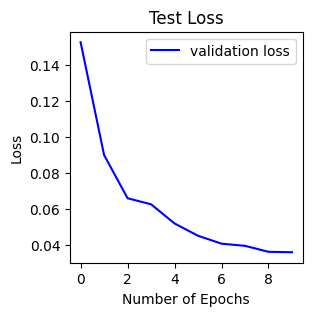

In [12]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


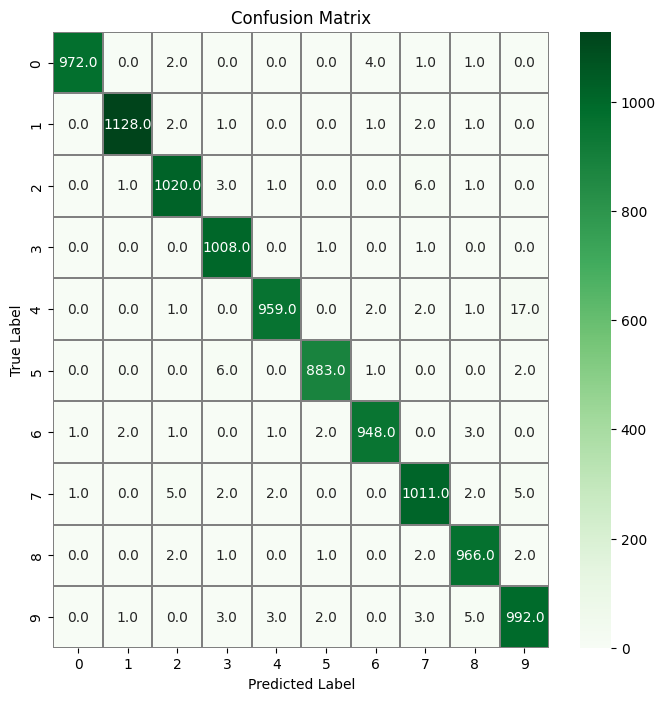

In [13]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(testX)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(testY,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()